### *Data Analysis*
##  LDA on the Speaker Corpus - U.S. 
---
*conducted in April 2022*

In [17]:
# Import necessary libraries
import nltk, re, pprint
import json
from nltk import word_tokenize
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import nltk.data
import os.path 
import glob
import pandas as pd
import os
import re
from nltk.corpus import PlaintextCorpusReader 
from nltk.app import concordance
from nltk.corpus import BracketParseCorpusReader
import numpy as np
import contractions
import statsmodels.formula.api as smf
import altair as alt
import tmtoolkit
import spacy as spacy
import logging, warnings
from tmtoolkit.corpus import Corpus
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
nltk.download('omw-1.4')
import pickle
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import docx


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
# Prerequisites: stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
# Add sample specific stop words that are redundant and have no substantial relevance; also add words that are project-specific stopwords
stopwords.add('president')
stopwords.add('mr.')
stopwords.add('mrs.')
stopwords.add('ms.')
stopwords.add('mr')
stopwords.add('mrs')
stopwords.add('ms')
stopwords.add('commission')
stopwords.add('congress')
stopwords.add('speaker')
stopwords.add('also')
stopwords.add('artificial')
stopwords.add('intelligence')
stopwords.add('ai')
stopwords.add('pro')
stopwords.add('tempore')
stopwords.add('representative')
stopwords.add('thank')
stopwords.add('dear')
stopwords.add('rapporteur')
stopwords.add('lady')
stopwords.add('committee')
stopwords.add('report')
stopwords.add('legislation')
stopwords.add('like')
stopwords.add('subcommittee')
stopwords.add('gentleman')
stopwords.add('r')
stopwords.add('colleague')
stopwords.add('madam')
stopwords.add('ha')
stopwords.add('wa')
stopwords.add('for')
stopwords.add('in')
stopwords.add('-')
stopwords.add(',')
stopwords.add('and')
stopwords.add('house')
stopwords.add('chairwoman')
stopwords.add('agency')
stopwords.add('sponsor')
stopwords.add('gentlewoman')
stopwords.add('verts')
stopwords.add('renew')
stopwords.add('bill')
stopwords.add('datum')
stopwords.add('year')
stopwords.add('amendment')
stopwords.add('president')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
### 1. Load in dataframe and pre-process U.S. datasets
---

In [118]:
# Open prepared dataframe
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis')
with open('raw_corpus_individual_us.csv') as f:
    corpus = pd.read_csv(f)
corpus.drop('Unnamed: 0', axis=1, inplace=True)
f.close()
df = corpus[['level', 'speaker', 'gender', 'state', 'house_of_rep', 'party', 'text']]

# Data from text column to list
data = df.text.values.tolist()

# Remove single quotes and slashes
data = [re.sub("\'", "", sent) for sent in data]

# Clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [26]:
# Define functions for pre-processing: stopwords, create bigrams, lemmatization
## Lemmatization gets the root, for ref, see: https://spacy.io/api/annotation
def rm_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
words_nostops = rm_stopwords(data_words)

# Form Bigrams
words_bigrams = bigrams(words_nostops)

# Initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm")

# Lemmatize, keep noun, adj, vb, adv
ready_corpus_us = lemmatize(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(ready_corpus_us[:1])

[['rise', 'bipartisan', 'act', 'honor', 'value', 'support', 'servicemember', 'family', 'strengthen', 'security', 'advance', 'leadership', 'world', 'staff', 'patriotic', 'persistent', 'leadership', 'reflect', 'brilliance', 'diversity', 'whole', 'honor', 'responsibility', 'meet', 'need', 'servicemember', 'sacrifice', 'freedom', 'family', 'provide', 'pay_raise', 'man', 'woman', 'uniform', 'strengthen', 'parental_leave', 'caregiver', 'expand', 'access', 'child', 'care', 'improve', 'financial', 'security', 'military', 'member', 'include', 'low', 'income', 'family', 'member', 'live', 'disability', 'protect', 'military', 'community', 'pfas', 'forever', 'make', 'historic', 'change', 'well', 'combat', 'sexual_assault', 'military', 'include', 'create', 'office', 'special', 'victim', 'prosecutor', 'prosecute', 'crime', 'criminalize', 'sexual_harassment', 'ucmj', 'military', 'justice', 'improve', 'military', 'health', 'care', 'include', 'relate', 'reproductive', 'healthof', 'woman', 'suicide', 'pr

---
### 2. Build LDA model US
---

In [133]:
# Create Dictionary
id2word = corpora.Dictionary(ready_corpus_us)

# Create Corpus
texts = ready_corpus_us

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in texts]

# TDF readable for humans
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]

[[('academia', 1),
  ('access', 1),
  ('act', 1),
  ('action', 2),
  ('advance', 1),
  ('adversary', 1),
  ('afghan', 1),
  ('age', 1),
  ('alliance', 1),
  ('allow', 1),
  ('ally', 1),
  ('authorize', 1),
  ('basis', 1),
  ('bipartisan', 4),
  ('blessing', 1),
  ('brilliance', 1),
  ('bring', 1),
  ('build', 1),
  ('care', 2),
  ('caregiver', 1),
  ('change', 1),
  ('child', 1),
  ('combat', 2),
  ('common', 1),
  ('community', 1),
  ('consecutive', 1),
  ('continue', 1),
  ('counter', 1),
  ('create', 1),
  ('crime', 1),
  ('criminalize', 1),
  ('cybersecurity', 1),
  ('defense', 3),
  ('desk', 1),
  ('deter', 1),
  ('development', 1),
  ('disability', 1),
  ('diversity', 1),
  ('effort', 2),
  ('expand', 1),
  ('extremism', 1),
  ('family', 3),
  ('fight', 1),
  ('financial', 1),
  ('fix', 1),
  ('forever', 1),
  ('founder', 1),
  ('freedom', 1),
  ('hbcus', 1),
  ('health', 1),
  ('healthof', 1),
  ('help', 1),
  ('historic', 2),
  ('honor', 3),
  ('immigrant', 1),
  ('improve', 2)

---
#### 2.1 Run simple LDA model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print out topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ready_corpus_us, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.556052438972246

Coherence Score:  0.34802038768266946


In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.183557  0.041614       1        1  26.234727
5     -0.110776 -0.082792       2        1  22.490341
1     -0.123200 -0.104366       3        1  21.685699
18    -0.141856 -0.020042       4        1   8.548214
14    -0.114251  0.239420       5        1   5.226489
11    -0.118482 -0.003722       6        1   3.207385
9     -0.020113  0.048256       7        1   2.917775
4     -0.053062 -0.085814       8        1   2.859805
13    -0.020545 -0.008297       9        1   1.332340
0      0.048323 -0.083791      10        1   1.252179
6      0.025234  0.005551      11        1   0.934309
3      0.050263 -0.023368      12        1   0.933118
16     0.061967  0.008802      13        1   0.698338
15     0.038207 -0.027648      14        1   0.624114
8      0.068684 -0.002491      15        1   0.522880
10     0.112125  0.022279      16        1   0.458412
19     0.113438  0.017553      17        1   0.059779
12     0.121465  0.018220      18        1   0.004773
2      0.117088  0.021295      19        1   0.004713
17     0.129048  0.019339      20        1   0.004611, topic_info=         Term        Freq       Total Category  logprob  loglift
105  research  213.000000  213.000000  Default  30.0000  30.0000
126   support  288.000000  288.000000  Default  29.0000  29.0000
248      work  276.000000  276.000000  Default  28.0000  28.0000
408        go  254.000000  254.000000  Default  27.0000  27.0000
32    defense  223.000000  223.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
58   increase    0.000496  117.587303  Topic20  -8.1902  -2.3921
730   science    0.000491   98.260457  Topic20  -8.1995  -2.2219
181    ensure    0.000488  105.417293  Topic20  -8.2059  -2.2986
216    people    0.000498  200.391069  Topic20  -8.1859  -2.9210
51       help    0.000488  144.957644  Topic20  -8.2057  -2.6170

[1416 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
144       1  0.337162   able
144       2  0.337162   able
144       3  0.037462   able
144       4  0.037462   able
144       6  0.037462   able
...     ...       ...    ...
249       8  0.029163  yield
249       9  0.014582  yield
249      10  0.058326  yield
249      14  0.014582  yield
1458      4  0.804480   yuan

[2912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 2, 19, 15, 12, 10, 5, 14, 1, 7, 4, 17, 16, 9, 11, 20, 13, 3, 18])

---
#### 2.2 Run more mature Mallet model

In [39]:
# Download: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
path_mallet = '/Users/charlottekaiser/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 3465
total tokens: 33554
<10> LL/token: -8.81557
<20> LL/token: -8.41445
<30> LL/token: -8.30634
<40> LL/token: -8.2224

0	2.5	thing people work lot talk happen year product meet make point national percent big produce idea place time cost basically 
1	2.5	act american party program face world industry month make domestic foreign access reach endless_fronti funding economy potential reason depend develop 
2	2.5	require support department plan secretary readiness address colleague operation personnel strengthen develop provision enhance project establish ability maintain safety child 
3	2.5	include security support authorize provide proud vehicle ship nation future make defense information effort critical development cyber center infrastructure range 
4	2.5	fund ensure program risk capability force include strategy woman base increase large construction percent command high reduce small additional conduct 
5	

In [40]:
# Print out topics
topics = ldamallet.print_topics(num_words=4)
for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=ready_corpus_us, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

(0, '0.058*"people" + 0.046*"thing" + 0.035*"work" + 0.025*"talk"')
(1, '0.038*"party" + 0.035*"make" + 0.032*"country" + 0.024*"national"')
(2, '0.055*"require" + 0.043*"department" + 0.030*"defense" + 0.025*"secretary"')
(3, '0.068*"security" + 0.037*"include" + 0.035*"nation" + 0.031*"authorize"')
(4, '0.046*"woman" + 0.025*"military" + 0.023*"veteran" + 0.023*"risk"')
(5, '0.038*"include" + 0.025*"make" + 0.022*"power" + 0.021*"number"')
(6, '0.038*"american" + 0.032*"semiconductor" + 0.030*"global" + 0.025*"invest"')
(7, '0.051*"money" + 0.039*"people" + 0.033*"study" + 0.029*"spend"')
(8, '0.058*"support" + 0.032*"colleague" + 0.030*"urge" + 0.029*"federal"')
(9, '0.112*"military" + 0.063*"defense" + 0.036*"ndaa" + 0.029*"servicemember"')
(10, '0.035*"part" + 0.035*"state" + 0.033*"end" + 0.025*"vote"')
(11, '0.039*"time" + 0.032*"provide" + 0.029*"support" + 0.025*"threat"')
(12, '0.032*"issue" + 0.028*"military" + 0.028*"process" + 0.023*"important"')
(13, '0.038*"terrorist" + 

---
#### 2.3 Find coherence scores for LDA models with different number of topics and identify most coherent model

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [70]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=ready_corpus_us, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 3465
total tokens: 33554
<10> LL/token: -8.17287
<20> LL/token: -7.99563
<30> LL/token: -7.93796
<40> LL/token: -7.90483

0	25	military support work defense time include increase provide threat member ensure department provision pass require staff woman important strong process 
1	25	make research technology national security people world act investment innovation american nation percent today colleague country development science critical effort 

<50> LL/token: -7.87969
<60> LL/token: -7.8756
<70> LL/token: -7.87275
<80> LL/token: -7.87286
<90> LL/token: -7.86501

0	25	support military defense work include time provide ensure threat member provision department bipartisan pass require staff increase important woman process 
1	25	make research technology national people security act world investment innovation american nation percent today colleague development science critical continue country 

<100> LL/token: 

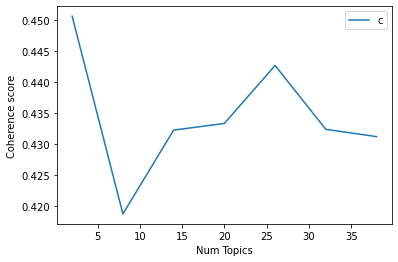

In [97]:
# Visualize 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
# Save as file
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points')
plt.savefig('coherence-check_us.png')

In [72]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4506
Num Topics = 8  has Coherence Value of 0.4188
Num Topics = 14  has Coherence Value of 0.4323
Num Topics = 20  has Coherence Value of 0.4334
Num Topics = 26  has Coherence Value of 0.4427
Num Topics = 32  has Coherence Value of 0.4324
Num Topics = 38  has Coherence Value of 0.4312


---
#### 2.4 Run LDA Mallet model that is most coherent as per step 2.3

In [130]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)

# Print out topics
topics = optimal_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.019*"support" + 0.019*"military" + 0.014*"defense" + 0.013*"work" + 0.011*"include" + 0.008*"bipartisan" + 0.008*"provide" + 0.007*"time" + 0.007*"ensure" + 0.007*"member"')
(1, '0.014*"make" + 0.013*"research" + 0.013*"technology" + 0.013*"national" + 0.012*"people" + 0.009*"world" + 0.009*"investment" + 0.008*"innovation" + 0.008*"american" + 0.008*"percent"')


In [88]:
# Store prevalence scores of all topics across documents (i.e. speaker entries)
for i in range(0,79):
    globals()[f"prev{i}"] = optimal_model[corpus[i]]

In [150]:
prev_score_us = [prev0, prev1 ,  prev2 ,  prev3 ,  prev4 ,  prev5 ,  prev6 ,  prev7 ,  prev8 ,  prev9,  prev10 ,  prev11 , prev12 , prev13, prev14, prev15, prev16, prev17, prev18, prev19, prev20, prev21, prev22, prev23, prev24 , prev25, prev26, prev27, prev28, prev29, prev30, prev31, prev32, prev33, prev34, prev35, prev36, prev37, prev38, prev39, prev40, prev41, prev42, prev43, prev44, prev45, prev46, prev47, prev48, prev49, prev50, prev51, prev52, prev53, prev54, prev55, prev56, prev57, prev58, prev59, prev60, prev61, prev62, prev63 ,  prev64, prev65, prev66 , prev67 , prev68 , prev69 , prev70 , prev71 , prev72 , prev73 , prev74 , prev75 , prev76 , prev77 , prev78]

In [96]:
# Find topic most dominant for each debate
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=ready_corpus_us):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ready_corpus_us)

# Format
df_topics_aggregate = df_topic_sents_keywords.reset_index()
df_topics_aggregate.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_15602/154131465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_15602/154131465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [151]:
#Combine df with info on the speaker with the info from the newly created dataframe holding info on keywords, dominant topics, topic contribution etc. 
df["Document_No"] = df_topics_aggregate["Document_No"]
df['Dominant_Topic'] = df_topics_aggregate['Dominant_Topic']
df['Topic_Perc_Contrib'] = df_topics_aggregate['Topic_Perc_Contrib']
df['Keywords'] = df_topics_aggregate['Keywords']
df['text'] = df_topics_aggregate['Text']
df["prevalenc_of_topics"] = prev_score_us

In [166]:
# Add the keywords with prevalences
df["Dominant_topic"] = np.nan
df.loc[df['Dominant_Topic'] == 0, ['Keywords']] = 'National_security'
df.loc[df['Dominant_Topic'] == 1, ['Keywords']] = 'Domestic_us_economy'

In [160]:
# Save dataframe
df.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/LDA_mallet_us.csv')  

In [163]:
# Create dataframe for table output for word
df_word = df.drop(['text', 'prevalenc_of_topics', 'Document_No', 'Dominant_Topic', 'level'], axis=1)

In [164]:
# Save to table in word
doc = docx.Document('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points/LDA-table-us.docx')

t = doc.add_table(df_word.shape[0]+1, df_word.shape[1])

# add the header rows.
for j in range(df_word.shape[-1]):
    t.cell(0,j).text = df_word.columns[j]

# add the rest of the data frame
for i in range(df_word.shape[0]):
    for j in range(df_word.shape[-1]):
        t.cell(i+1,j).text = str(df_word.values[i,j])

# save the doc
doc.save('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points/LDA-table-us.docx')


---
#### 2.5 Visualize LDA Mallet model ran in 2.4

In [131]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [134]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.289511  0.0       1        1  52.880204
0     -0.289511  0.0       2        1  47.119796, topic_info=          Term        Freq       Total Category  logprob  loglift
126    support  351.000000  351.000000  Default  30.0000  30.0000
75    military  345.000000  345.000000  Default  29.0000  29.0000
32     defense  264.000000  264.000000  Default  28.0000  28.0000
70        make  287.000000  287.000000  Default  27.0000  27.0000
105   research  268.000000  268.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
201  important  106.826289  187.345083   Topic2  -5.1415   0.1907
110   security   85.461031  210.975622   Topic2  -5.3647  -0.1512
602    program   74.216159  110.923256   Topic2  -5.5058   0.3506
636     system   70.842697  100.445195   Topic2  -5.5523   0.4033
195       good   70.842697  163.202490   Topic2  -5.5523  -0.0821

[159 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
363       2  0.988105  absolutely
0         1  0.985277    academia
2         1  0.668956         act
2         2  0.331758         act
1195      2  1.004042     address
...     ...       ...         ...
141       2  1.001863       woman
248       1  0.281483        work
248       2  0.718369        work
142       1  1.000518       world
249       2  0.997452       yield

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [135]:
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points')
pyLDAvis.save_html(vis, 'pyLDAvis_us.html')
pyLDAvis.save_json(vis, 'pyLDAvis_us.json')